In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahmoudfaridd","key":"9260ba3d66f8d926d8ae7ced5493ade8"}'}

In [ ]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aninda/etci-2021-competition-on-flood-detection

100% 4.13G/4.13G [00:35<00:00, 72.5MB/s]
100% 4.13G/4.13G [00:35<00:00, 124MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = "etci-2021-competition-on-flood-detection.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


In [ ]:
 

import numpy as np  
import pandas as pd  
import cv2
from PIL import Image
from fastai.data.all import *
from fastai.vision.all import *
import glob
from fastai.metrics import *
from sklearn.metrics import jaccard_score,confusion_matrix
import os
 

In [ ]:
def get_filename(filepath):
    return os.path.split(filepath)[1]

In [ ]:
train_dir = '/content/train/train'

vv_image_paths = sorted(glob.glob(train_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
     
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

   
    flood_image_name = vv_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

 
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


train_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}


train_df = pd.DataFrame(train_paths)

print(train_df.shape)
train_df.head()

(33405, 5)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path,region
0,/content/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-0_vv.png,/content/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-0_vh.png,/content/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-0.png,/content/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-0.png,bangladesh
1,/content/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-10_vv.png,/content/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-10_vh.png,/content/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-10.png,/content/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-10.png,bangladesh
2,/content/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-11_vv.png,/content/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-11_vh.png,/content/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-11.png,/content/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-11.png,bangladesh
3,/content/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-12_vv.png,/content/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-12_vh.png,/content/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-12.png,/content/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-12.png,bangladesh
4,/content/train/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-13_vv.png,/content/train/train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-13_vh.png,/content/train/train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-13.png,/content/train/train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-13.png,bangladesh


In [ ]:
def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

In [ ]:
def visualize(df_row, figsize=[25, 15]):
    
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

   
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

   
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

 
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
     
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0
        
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)
 
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

     
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


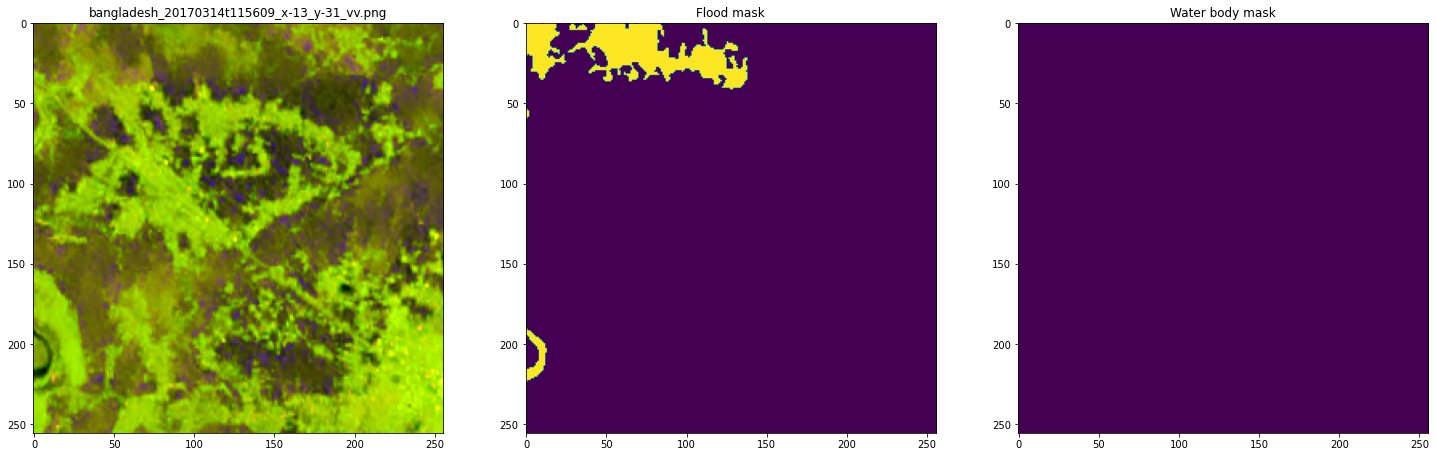

In [ ]:
visualize(train_df.iloc[200])

In [ ]:
def get_files(_):
    return train_df.iloc[:]

def get_x(df_row):
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
  
  
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0)
    vh_image = cv2.imread(vh_image_path, 0)
    rgb_image = s1_to_rgb(vv_image, vh_image).astype(np.uint8)
   
    return rgb_image

def get_y(df_row):
    water_body_label_path = df_row['flood_label_path']
    water_body_label_image = cv2.imread(water_body_label_path, 0).astype(np.uint8)
    
    return water_body_label_image

In [ ]:
codes = np.array(['land','water'])

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'land': 0, 'water': 1}

In [ ]:
land_code = name2id['land']
land_code

0

In [ ]:
def acc_seg(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != 2
    mask[:,0,0] = 1
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

def iou_seg(pred,target):
    pred = pred.argmax(dim=1).flatten()
    target = target.flatten()
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    cm = confusion_matrix(target, pred,labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    iou = tp / (tp + fp + fn + 0.001)
 
    return iou


In [ ]:
db = DataBlock(blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_files,
    splitter=RandomSplitter(valid_pct = 0.2,seed=2021),
    get_x = get_x,
    get_y = get_y,

    batch_tfms=[*aug_transforms(),IntToFloatTensor(div_mask=255),Normalize.from_stats(*imagenet_stats)])

In [ ]:
db.summary(source=Path(''))

Setting-up type transforms pipelines
Found 33405 items
2 datasets of sizes 26724,6681
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> PILBase.create

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      vv_image_path                       /content/train/train/nebraska_20171222t002118/tiles/vv/nebraska_20171222t002118_x-20_y-21_vv.png
vh_image_path                       /content/train/train/nebraska_20171222t002118/tiles/vh/nebraska_20171222t002118_x-20_y-21_vh.png
flood_label_path              /content/train/train/nebraska_20171222t002118/tiles/flood_label/nebraska_20171222t002118_x-20_y-21.png
water_body_label_path    /content/train/train/nebraska_20171222t002118/tiles/water_body_label/nebraska_20171222t002118_x-20_y-21.png
region                                                                                                                      nebraska
Name: 17938, dtype: object
    applying get_x gives
      [[[108 176   0]
  [1

In [ ]:
dls = db.dataloaders(source=Path(''),bs=4)

In [ ]:
weights = torch.tensor([0.1,0.9]).cuda()
 
learn = unet_learner(dls, resnet18, pretrained = True, loss_func=CrossEntropyLossFlat(weight=weights,axis=1),metrics=[acc_seg,iou_seg])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,acc_seg,iou_seg,time
0,0.138032,0.132905,0.987429,0.348888,26:18
1,0.128461,0.104049,0.984756,0.331600,26:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


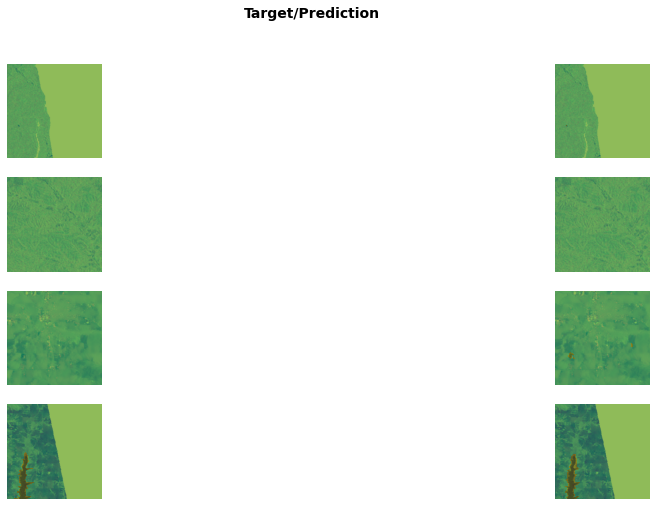

In [ ]:
learn.show_results(max_n=4, figsize=(18,8))

In [ ]:
!ls /content/test/test_internal

redrivernorth_20190104t002247  redrivernorth_20190410t002246
redrivernorth_20190116t002247  redrivernorth_20190422t002247
redrivernorth_20190128t002246  redrivernorth_20190504t002247
redrivernorth_20190209t002246  redrivernorth_20190516t002248
redrivernorth_20190221t002246  redrivernorth_20190528t002248
redrivernorth_20190305t002246  redrivernorth_20190609t002249
redrivernorth_20190317t002246  redrivernorth_20190621t002250


In [ ]:
test_dir = '/content/test/test_internal'

vv_image_paths = sorted(glob.glob(test_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]


vh_image_paths, region_names = [], []
for i in range(len(vv_image_paths)):
   
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(test_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

   
   
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)


test_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'region': region_names
}


test_df = pd.DataFrame(test_paths)
test_df.sort_values(by=['vv_image_path'],inplace=True)  

print(test_df.shape)
test_df.head()

(12348, 3)


,vv_image_path,vh_image_path,region
0,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vv/redrivernorth_20190104t002247_x-0_y-0_vv.png,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vh/redrivernorth_20190104t002247_x-0_y-0_vh.png,redrivernorth
1,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vv/redrivernorth_20190104t002247_x-0_y-10_vv.png,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vh/redrivernorth_20190104t002247_x-0_y-10_vh.png,redrivernorth
2,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vv/redrivernorth_20190104t002247_x-0_y-11_vv.png,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vh/redrivernorth_20190104t002247_x-0_y-11_vh.png,redrivernorth
3,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vv/redrivernorth_20190104t002247_x-0_y-12_vv.png,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vh/redrivernorth_20190104t002247_x-0_y-12_vh.png,redrivernorth
4,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vv/redrivernorth_20190104t002247_x-0_y-13_vv.png,/content/test/test_internal/redrivernorth_20190104t002247/tiles/vh/redrivernorth_20190104t002247_x-0_y-13_vh.png,redrivernorth


In [ ]:
tdl = learn.dls.test_dl(test_df.iloc[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


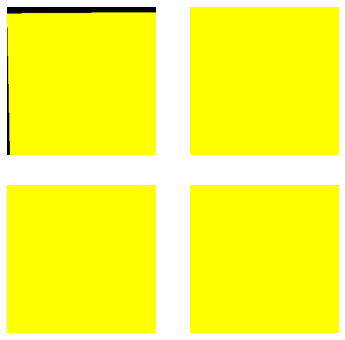

In [ ]:
tdl.show_batch()

In [ ]:
from tqdm.notebook import tqdm

final_predictions = []

learn.model.eval()
with torch.no_grad():
    for batch in tqdm(tdl):
         
        image = batch[0]
 
        pred = learn.model(image)

         class_pred = pred.argmax(dim=1)

        
        class_pred = class_pred.detach().cpu().numpy()

         
        final_predictions.append(class_pred.astype('uint8'))


 
final_predictions = np.concatenate(final_predictions, axis=0)
 
print(final_predictions.shape)
 

  0%|          | 0/3087 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


(12348, 256, 256)


In [ ]:
save_path = '/content/submission.npy'
np.save(save_path, final_predictions, fix_imports=True, allow_pickle=False)

In [ ]:
import subprocess
subprocess.run(['zip', 'submission.zip', save_path])

CompletedProcess(args=['zip', 'submission.zip', '/content/submission.npy'], returncode=0)